## Introduction
This is an implementation of the artistic neural network as described in this [paper](www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). VGG pretrained model weights can be downloaded from [here](http://www.vlfeat.org/matconvnet/models/). Use imagenet-vgg-verydeep-19.mat and imagenet-vgg-verydeep-16.mat.  
  
Checklist for dependencies:
 - Tensorflow, preferably with GPU support
 - numpy
 - scipy
 - PIL
 - If you want to run in notebook, IPython notebook is also required.

## Get the pretrained weights
The following bash code will automatically download the models. VGG19 is approximately 510M and VGG16 is approximately 491M. Comment out using "#" if you already have the model downloaded somewhere else. But don't forget to change the model path later (you will see it).

In [37]:
!if [ ! -e "models/imagenet-vgg-verydeep-19.mat" ]; then echo "VGG19 does not exist"; wget -P models/ http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat; fi
!if [ ! -e "models/imagenet-vgg-verydeep-16.mat" ]; then echo "VGG16 does not exist"; wget -P models/ http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-16.mat; fi

In [38]:
from __future__ import print_function
import os
import gc
import sys
import numpy as np
import tensorflow as tf
import scipy
import scipy.io
import PIL.Image
import cPickle as pickle
from IPython.display import clear_output, Image, display
from io import BytesIO

## Define the base class for the VGG model
This class will load the model accordingly, and wrap the pretrained weights with a Tensorflow graph

In [39]:
class VGG(object):
    
    def __init__(self, path):
        self.content_layer = None
        self.style_layer = None
        self.path = path
        self.weights = scipy.io.loadmat(self.path)['layers']
    
    def create_graph(self, input_shape):
        """
        The pretrained model contains the layer name and layer type (i.e. pool, conv etc.)
        To access those information, we can do the index access:
        vgg_layers[0]      [0]       [0]      [0]      [2]                                    [0]      [0] ## weight
        vgg_layers[0]      [0]       [0]      [0]      [2]                                    [0]      [1] ## bias
                  always 0 |layer idx|always 0|always 0|0:layer name; 1:layer type; 2: weights|always 0|0:weight; 1:bias
        vgg_layers[0][30][0][0][0][0] # to access layer name
        vgg_layers[0][30][0][0][1][0] # to access layer type
        
        Note that the fully connected layers and the softmax are not required for this task, therefore we will skip it. 
        The fully connected layers have name fc* (It's type is conv though).
        """
        if self.path == None:
            raise Exception("Run from the child class")
            
        vgg_layers = self.weights
        num_layers = len(vgg_layers[0])
        
        graph = {}
        layer_names = []
        graph["input"] = tf.Variable(np.zeros(input_shape), dtype=tf.float32)
        prev = "input"
        layer_names.append("input")
        
        for idx in range(num_layers):
            
            layer_name = vgg_layers[0][idx][0][0][0][0]
            layer_type = vgg_layers[0][idx][0][0][1][0]
            
            if layer_name[:2] == "fc":
                break                     # stop before adding the first fc layer
            
            layer_names.append(layer_name)
            
            if layer_type == "conv":
                W = vgg_layers[0][idx][0][0][2][0][0]
                b = vgg_layers[0][idx][0][0][2][0][1]
                W = tf.constant(W)        # we don't want to update the parameters
                b = tf.constant(np.reshape(b, (b.size)))
                graph[layer_name] = tf.nn.conv2d(graph[prev], filter=W, strides=[1, 1, 1, 1], padding="SAME") + b
            elif layer_type == "relu":
                graph[layer_name] = tf.nn.relu(graph[prev])
            elif layer_type == "pool":    # according to the paper, average pooling behaves better
                graph[layer_name] = tf.nn.avg_pool(graph[prev], ksize=[1, 2, 2, 1], 
                                                   strides=[1, 2, 2, 1], padding="SAME")
            else:
                raise Exception("Unknown layer")
            
            prev = layer_name
        return graph, layer_names
    
    def get_layer_names(self):
        return self.layer_names
    
    def get_instance(model_path, force=False):
        raise Exception("Do not instantiate this class")

## Two child classes
Those two classes specify the parameters such as which layer to use for content loss and which layers are used for style loss. Modify according to your needs. Also, note that those two classes are implemented with singleton support. Using singleton prevents the overhead for loading the weights on everyrun.

In [40]:
class VGG19(VGG):
    
    instance = None
    
    def __init__(self, model_path):
        super(VGG19, self).__init__(model_path)
        self.content_layer = "conv4_2"
        self.style_layer = [
            ("relu1_1", 0.2),
            ("relu2_1", 0.2),
            ("relu3_1", 0.2),
            ("relu4_1", 0.2),
            ("relu5_1", 0.2)
        ]
    
    def get_instance(model_path, force=False):
        """
        Singleton to avoid load graph on every run
        If force is True, then force reload
        """
        if VGG19.instance == None or force:
            VGG19.instance = VGG19(model_path)
        return VGG19.instance
    
    get_instance = staticmethod(get_instance)

In [41]:
class VGG16(VGG):
    
    instance = None
    
    def __init__(self, model_path):
        super(VGG16, self).__init__()
        self.graph = self.load_model()
        self.content_layer = "relu4_2"
        self.style_layer = [
            ("relu1_2", 0.5),
            ("relu2_2", 1.0),
            ("relu3_3", 1.5),
            ("relu4_3", 1.5),
            ("relu5_3", 4.0)
        ]
    
    def get_instance(model_path, force=False):
        """
        Singleton to avoid load graph on every run
        If force is True, then force reload
        """
        if VGG16.instance == None or force:
            VGG16.instance = VGG16(model_path)
        return VGG16.instance
    
    get_instance = staticmethod(get_instance)

Factory to create the corresponding VGG model

In [42]:
class VGGFactory(object):
    
    def factory(name, model_path, force=False):
        """
        The factory to create the corresponding model we will use
        Available names include "VGG16" and "VGG19"
        If force is set, then force reload the graph
        """
        if name == "VGG16": return VGG16.get_instance(model_path, force)
        if name == "VGG19": return VGG19.get_instance(model_path, force)
    
    factory = staticmethod(factory)

## Class for real training
The MagicPen class, as its name says, draws intermixed pictures. To run, you need to provide which VGG model you want to use (VGG19 or VGG16), coupled with the path of the model (see the bash script at the top for the location) and the path of the style image. You don't need to provide alpha (the content loss weight) or beta (the style loss weight) during the object instantiation time, but you do need to set them before calling draw().

In [92]:
class MagicPen(object):
    """
    The actual class that carries out the image generation
    """
    
    # means for RGB channels. I believe it's the training set average for the pretrained model,
    # according to this: https://gist.github.com/ksimonyan/211839e770f7b538e2d8. Also various 
    # sources agree on those values.
    IMG_MEAN = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,1,3))
    
    RANDOM_RATE = 0.4 # The amount of interpolation of random image to the content image when 
                      # creating the base image
    
    def __init__(self, vgg_name, vgg_path, style_path, alpha=None, beta=None, iterations=None):
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        print("Load graph")
        self.vgg = VGGFactory.factory(vgg_name, vgg_path)
        self.style_path = style_path
        self.opt_algo = "lbfgsb"
        print("OK")
        
    def _generate_base(self, content):
        """
        Add some noise to the content image to get the base image
        """
        random_img = np.random.uniform(-20, 20, content.shape)
        return MagicPen.RANDOM_RATE * random_img + content * (1 - MagicPen.RANDOM_RATE)
        
    def _process_img(self, image):
        """
        Returns the image with 4 dimensions
        """
        image = np.float32(image)
        image = np.reshape(image, ((1,) + image.shape))
        image -= MagicPen.IMG_MEAN
        return image
    
    def set_alpha(self, alpha):
        self.alpha = alpha
        return self
    
    def set_beta(self, beta):
        self.beta = beta
        return self
    
    def set_iters(self, iterations):
        self.iterations = iterations
        return self
    
    def load_content(self, image_path, ratio=1.0):
        """
        Load the content image, with the option to resize the image. 
        ratio -- the ratio of new size to old size. A float number
        """
        image = PIL.Image.open(image_path)
        image = image.resize((int(image.size[0] * ratio), int(image.size[1] * ratio)), PIL.Image.ANTIALIAS)
        self.content = self._process_img(image)
        self.base = self._generate_base(self.content)
        return self
    
    def gram_matrix(self, F, N, M):
        """
        The gram matrix G.
        F -- the features
        N -- number of filters
        M -- hight x width of one feature map 
        Names as per paper
        """
        G = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(G), G)
    
    def content_loss(self, sess, graph):
        """
        Compute the context loss as described in the paper. We only need to do the forward 
        pass once on the content image
        
        sess -- the current session
        content_img -- the content image. should be a numpy array with dimension [1, hight, width, 3]
        Note: the dimension of the image should match with the one set at resize_input.
        Also, the image should be centered. The mean to subtract will be the training set mean of the VGG network.
        """
        graph["input"].assign(self.content).eval()
        P = sess.run(graph[self.vgg.content_layer])
        F = graph[self.vgg.content_layer]
        N = P.shape[3]  # number of filters
        M = P.shape[1] * P.shape[2] # hight x width of one feature map 
        return 0.5 * tf.reduce_sum(tf.pow(F - P, 2))
        
    
    def style_loss(self, sess, graph):
        """
        Compute the style loss as described in the papaer. Again, only do forward pass once for style image
        
        sess -- the current session
        graph - the current graph
        """
        loss = 0.0
        style_img = PIL.Image.open(self.style_path) \
                       .resize((self.content.shape[2], self.content.shape[1]), PIL.Image.ANTIALIAS)
        style_img = self._process_img(style_img)

        graph["input"].assign(style_img).eval()
        for key, w in self.vgg.style_layer:
            print(key)
            P = sess.run(graph[key])
            F = graph[key]
            N = P.shape[3]  # number of filters
            M = P.shape[1] * P.shape[2] # hight x width of one feature map 
            A = self.gram_matrix(P, N, M)
            G = self.gram_matrix(F, N, M)
            loss += ((1.0 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2)) * w)
            
        return loss
    
    def set_optimize_algo(self, algo):
        if algo == "adam" or algo == "lbfgsb":
            self.opt_algo = algo
        else:
            raise Exception('Invalid optimization algorithm choice. Available options are: "adam" and "lbfgsb"')
        return self
    
    def draw(self):
        """
        The function to finally generate the image
        """
        graph, _ = self.vgg.create_graph(self.content.shape)
        image = None
        
        with tf.Session() as sess:
            print("initialize variables")
            sess.run(tf.global_variables_initializer())
            print("compute content loss")
            content_loss = self.content_loss(sess, graph) * self.alpha
            print("compute style loss")
            style_loss   = self.style_loss(sess, graph) * self.beta
            print("total variational loss")
            total_loss   = content_loss + style_loss
            
            train_step   = tf.train.AdamOptimizer(2.0).minimize(total_loss)
            
            print("reinitialize the variables")
            sess.run(tf.global_variables_initializer())
            graph["input"].assign(self.base).eval()
            
            if self.opt_algo == "adam":
                ##### Adam optimization algorithm
                print("optimization using adam starts")
                for i in range(self.iterations):
                    sess.run(train_step)
                    if (i + 1) % 10 == 0:
                        print(".", end=" ")
                    if (i + 1) % 100 == 0:
                        c_loss = content_loss.eval()
                        s_loss = style_loss.eval()
                        v_loss = tv_loss.eval()
                        t_loss = total_loss.eval()
                        print()
                        print("%f, %f, %f, %f" % (c_loss, s_loss, v_loss, t_loss))
            
            if self.opt_algo == "lbfgsb":
                ##### L-BFGS-B optimization algorithm
                print("optimization using lbfgsb starts")
            
                step = [0]
                
                def _step(*args):
                    """
                    A hook to count the iteration number
                    """
                    step[0] = step[0] + 1
                    if (step[0] + 1) % 10 == 0:
                        print(".", end=" ")
                
                optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                            total_loss, method='L-BFGS-B',
                            options={'maxiter': self.iterations})
                optimizer.minimize(sess, step_callback=_step)
            
            image = graph["input"].eval()
        
        tf.reset_default_graph()
        
        image += MagicPen.IMG_MEAN
        
        return image

Trying to free up the object on multiple runs. Maybe helpful if Tensorflow fails to clean up the GPU memory.

In [93]:
try:
    del pen
except NameError:
    print("pen is not defined")
else:
    gc.collect()

Example run. The default algorithm is L-BFGS-B. Notice the model path

In [94]:
pen = MagicPen("VGG19", "models/imagenet-vgg-verydeep-19.mat", "pictures/styles/wave.jpg")

Load graph
OK


In [96]:
image = pen.load_content("pictures/scenery.jpg", ratio=0.8).set_alpha(0.1).set_beta(10000).set_iters(300).draw()

initialize variables
compute content loss
compute style loss
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
total variational loss
reinitialize the variables
optimization using lbfgsb starts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 20192309248.000000
  Number of iterations: 301
  Number of functions evaluations: 314


An auxiliary function to visualize the image. Same as in the Tensorflow deep dream tutorial

In [97]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

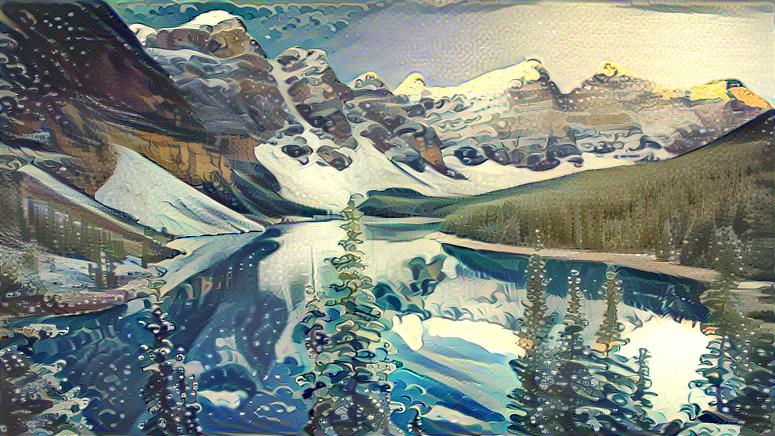

(436, 775, 3)


In [98]:
converted_image = np.clip((image[0]), 0, 255).astype('uint8')
showarray(converted_image)
print(converted_image.shape)